# Piper Gradient - Challenge 1
Kishan Patel  
mail@kishanpatel.dev

## Introduction

This is a final deliverable of a practicum while enrolled in the Master of Science in Analytics program at the Georgia Institute of Technology.

This project is a small component of the Piper Team's larger endeavor to provide a more comprehensive sample of social media posts. The project addresses Challenge 1 by creating models that cluster social media posts into semantic categories. The datasets of interest are a collection of Tweets associated with the American Jobs Plan promoted by the President Biden Administration. This project utilizes two methods to first create clusters of Tweets sharing similar opinions. Then the Tweets within the clusters are analyzed to determine which traits affect cluster assignments. 

The core project spans three stages. In the first step, the tweets are preprocessed to remove extraneous Twitter content. Then a common NLP pipeline of tokenization, stop-word removal, stemming, and lemmatization is completed before vectoring each Tweet using the Word2Vec protocol. In the second stage, the two methods of clustering are implemented. Method 1 makes use of similarity between Tweets and graph theory while Method 2 utilizes TF-IDF-weighted vectors and k-means clustering. In stage 3, the sentiment of each cluster is assessed. The clustering validity of each method is explored and the performance of both methods are compared. 

These stages are outlined below and set the procedure for the notebook. 

### Steps 
1. Preprocessing
    - Remove extraneous Tweet (emoji, url, hashtag, etc.) and lowercase
    - Tokenization
    - Remove stop words
    - Stemming
    - Lemmatization 
    - Vectorize Word2Vec (spaCy)
2. Algorithm Development
    - Method 1
        - Get cosine similarity between pairs
        - Generate graph (networkX)
        - Adjust similarity threshold for edges
    - Method 2
        - Revectorize with TF-IDF
        - k-means clustering
        - Optimize hyperparameter k
3. Cluster Assessment
    - Sentiment analysis of each cluster with VADER
    - Explore tweets within cluster to see clustering validity
    - Compare run time

## Step 1 - Preprocessing

First, all relevant libraries are imported and utility classes are defined.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import re
from pathlib import Path
from math import sqrt
import spacy
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

import nltk
# nltk.download('vader_lexicon')   # only needed if lexicon not already downloaded
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

In [2]:
# set up timer class
# taken from https://realpython.com/python-timer/

import time

class TimerError(Exception):    
    """A custom exception used to report errors in use of Timer class"""

class Timer:    
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        
# initialize timer
t = Timer()

Next the dataset is loaded. Experiments made use of all three files. For the presentation of this notebook, the medium file is loaded and processed. 

In [3]:
# load dataset 
file_small = Path('Data', 'Challenge1_Small.csv')
file_med = Path('Data', 'Challenge1_Medium.csv')
file_large = Path('Data', 'Challenge1_Large.csv')

df = pd.read_csv(file_med)
print(f'Original row count: {df.shape[0]:,}')

Original row count: 24,900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24900 entries, 0 to 24899
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        24900 non-null  int64  
 1   created_at        24900 non-null  object 
 2   id                24900 non-null  int64  
 3   reply_to_id       3722 non-null   float64
 4   screen_name       24900 non-null  object 
 5   coordinates       0 non-null      float64
 6   place             137 non-null    object 
 7   retweet_count     24900 non-null  int64  
 8   favorite_count    24900 non-null  int64  
 9   lang              24900 non-null  object 
 10  source            24900 non-null  object 
 11  is_quote_status   24900 non-null  bool   
 12  user_id           24900 non-null  int64  
 13  user_loc          15868 non-null  object 
 14  user_description  20464 non-null  object 
 15  verified          24900 non-null  bool   
 16  followers_count   24900 non-null  int64 

In [5]:
df.head()

,Unnamed: 0,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,...,user_loc,user_description,verified,followers_count,friends_count,favourites_count,statuses_count,listed_count,user_created_at,text
0,0,Fri Jun 04 02:08:02 +0000 2021,1400635422967885825,NaN,platopuppets,NaN,NaN,0,0,en,...,"Olympia, WA",b'English Teacher to the Stars (well... sort o...,False,142,489,282139,76457,1,Wed Nov 28 23:15:58 +0000 2012,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
1,1,Fri Jun 04 02:08:00 +0000 2021,1400635415846174721,NaN,MrChew3131,NaN,NaN,0,0,en,...,"St Augustine, FL",b'weather and chaos rule all',False,830,1222,622580,177972,40,Mon Feb 25 22:09:56 +0000 2013,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
2,2,Fri Jun 04 02:08:00 +0000 2021,1400635415707664387,NaN,WhistlingBatter,NaN,NaN,0,0,en,...,"Under The Rhine, Cincinnati",b'\xe2\x80\x9cit\xe2\x80\x99s all been a gorge...,False,602,581,112273,63355,18,Thu Mar 25 22:41:17 +0000 2010,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
3,3,Fri Jun 04 02:07:46 +0000 2021,1400635358774185989,NaN,BuzzEdition,NaN,NaN,0,0,en,...,North Carolina,"b""Hi I'm Susan from NC, Social Media Enthusias...",False,56949,14684,60443,348636,4514,Mon Jun 30 05:06:56 +0000 2008,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
4,4,Fri Jun 04 02:07:40 +0000 2021,1400635331800621056,NaN,CltrotLyn,NaN,NaN,0,0,en,...,PA,b'retired fed; old cat lady; atheist; Hillary ...,False,1791,4422,380004,397799,3,Sun Mar 03 22:31:33 +0000 2013,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...


With the data loaded in memory, the Tweet content located in the "text" column is extracted by decoding the byte representation into a python string. 

Following that, the Tweet text is cleaned. The team iterated between cleaning the text and performing clustering algorithms. Many of the steps involved in the cleaning process are chosen to aid in clustering performance. For example, the team found that duplicate Tweets are quite detrimental to clustering. In both methods, the presence of Tweets with nearly identical words resulted in clusters containing only the duplicate Tweets while all other Tweets were grouped together into a single giant cluster. Since $k$-means clustering recomputes the cluster average during its iterative learning process, duplicate Tweets pull the cluster center toward the Tweets that are repeated the most. This excluded less common Tweets from being assigned to a smaller cluster that could emphasize the Tweets’ distinctives. For this reason, the team chose to remove retweets beginning with the header “RT”.

In a similar investigative fashion, Twitter handles beginning with "@" and URLs are removed as they create noise in the clustering algorithms. Emojis are also removed to focus on the text portions of the Tweet. 

Other cleaning steps are standard and include converting the text to lowercase, replacing new line characters, and trimming extraneous white space at the beginning and end of the text. 

Afterward, any Tweets that have been reduced to empty strings and any lingering duplicate Tweets are dropped. 

In [6]:
t.start()
# decode tweet bytes
df['text_clean'] = df.text.apply(eval).apply(lambda x: x.decode('utf-8'))

In [7]:
# remove retweets due to varied truncation that causes clustering errors
mask = df.text_clean.str.contains(r"^RT", regex=True)

print(f'Dataset contains {mask.value_counts()[True]:,} retweets and {mask.value_counts()[False]:,} original tweets.')
print('Removing retweets to help with clustering algorithms.')

df = df.loc[~mask]

Dataset contains 17,748 retweets and 7,152 original tweets.
Removing retweets to help with clustering algorithms.


In [8]:
# define preliminary cleaning function 
def clean_tweets(text):
    text = text.str.lower()  # lower case 
#     text = text.str.replace(r'rt @\w+:\s?', '', regex=True)  # remove retweet prefix
    text = text.str.replace(r'@[\w\d]*', '', regex=True) # remove twitter handles
    text = text.str.replace(r'https?:\/\/[\w\d\.\/\?=&]*', ' ', regex=True) # remove urls
    text = text.str.replace(r'\n', ' ') # remove new line characters
    text = text.str.encode('ascii', 'ignore').str.decode('ascii')  # remove emojis    
    text = text.str.strip() # trim white space before and after text
    
    return text


# apply preliminary cleaning function
df.text_clean = df[['text_clean']].apply(clean_tweets, axis=0)

# remove tweets that have been reduced to empty strings 
# (mostly due to original tweet having only a hyperlink or emoji)
mask = df.text_clean.str.contains(r'^\s*$', regex=True)
df = df[~mask].reset_index(drop=True)

# remove duplicate tweets
df = df.drop_duplicates(subset=['text_clean']).reset_index(drop=True)

t.stop()

# new rowcount
print(f'New row count: {df.shape[0]:,}')

Elapsed time: 0.8987 seconds
New row count: 6,526


Here is a sample of an original Tweet and its cleaned version:

In [9]:
x = 10
print(df.loc[x, 'text'], end='\n\n')
print(df.loc[x, 'text_clean'])

b'DeJoy. Gaetz. Kushner. Trump &amp; family &amp; cabinet members. Seems we need to add another line item to the infrastructu\xe2\x80\xa6 https://t.co/LPyjz4qqJB'

dejoy. gaetz. kushner. trump &amp; family &amp; cabinet members. seems we need to add another line item to the infrastructu


### Use SpaCy to tokenize, lemmatize, and remove stop words while embedding via Word2Vec

Next, the spaCy library is used to parse the cleaned text. The large English library is loaded and used to tokenize each Tweet. Then stop words are removed while identifying parts of speech and lemmatizing each word.

More information about this pipeline can be found here: https://spacy.io/usage/spacy-101

In [10]:
# load spacy 
nlp = spacy.load('en_core_web_lg')

In [11]:
t.start()

# initialize arrays 
parsed_doc = []  # holds doc objects; could be expensive
tokens = []      # holds tokens as text (excluding stop word)
pos = []         # holds part of speech
lemma = []       # holds lemmatized value

for doc in nlp.pipe(df.text_clean):
    if doc.is_parsed:
        parsed_doc.append(doc)
        tokens.append([t.text for t in doc if not t.is_stop])
        pos.append([t.pos_ for t in doc if not t.is_stop])
        lemma.append([t.lemma_ for t in doc if not t.is_stop])
    else: 
        parsed_doc.append(None)
        tokens.append(None)
        pos.append(None)
        lemma.append(None)
    
df['parsed_doc'] = parsed_doc
df['tokens'] = tokens
df['pos'] = pos
df['lemma'] = lemma

t.stop()

df.head()



Elapsed time: 13.4834 seconds


,Unnamed: 0,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,...,favourites_count,statuses_count,listed_count,user_created_at,text,text_clean,parsed_doc,tokens,pos,lemma
0,18,Fri Jun 04 02:06:54 +0000 2021,1400635140976615428,1.400512e+18,mucha_carlos,NaN,NaN,0,0,en,...,33321,33642,61,Sat Jan 12 20:53:11 +0000 2013,b'@ddayen The problem here is that if the Bide...,the problem here is that if the biden wh pitch...,"(the, problem, here, is, that, if, the, biden,...","[problem, biden, wh, pitches, -, step, planthe...","[NOUN, PROPN, PROPN, VERB, PUNCT, NOUN, DET, N...","[problem, biden, wh, pitch, -, step, planthe, ..."
1,21,Fri Jun 04 02:06:22 +0000 2021,1400635005982883843,NaN,mlauriat,NaN,NaN,0,1,en,...,70464,84337,6,Mon Apr 27 22:17:26 +0000 2009,b'Joe Manchin: Any infrastructure bill must be...,joe manchin: any infrastructure bill must be b...,"(joe, manchin, :, any, infrastructure, bill, m...","[joe, manchin, :, infrastructure, bill, bipart...","[PROPN, PROPN, PUNCT, NOUN, NOUN, ADJ]","[joe, manchin, :, infrastructure, bill, bipart..."
2,22,Fri Jun 04 02:06:04 +0000 2021,1400634929088655368,1.400615e+18,Jen44284220,NaN,NaN,0,1,en,...,26400,4245,0,Mon Oct 12 20:24:45 +0000 2020,b'@PalmerReport @bdk1521 I personally he hopes...,i personally he hopes he beating them at their...,"(i, personally, he, hopes, he, beating, them, ...","[personally, hopes, beating, game, :, passy, i...","[ADV, VERB, VERB, NOUN, PUNCT, PROPN, NOUN, NO...","[personally, hope, beat, game, :, passy, infra..."
3,24,Fri Jun 04 02:06:01 +0000 2021,1400634918930051075,NaN,caroleigh21,NaN,NaN,0,0,en,...,35740,47385,4,Sat Aug 31 04:42:30 +0000 2013,b'#EndTheFilibuster #EndWorkingWithTrumplicans...,#endthefilibuster #endworkingwithtrumplicans p...,"(#, endthefilibuster, #, endworkingwithtrumpli...","[#, endthefilibuster, #, endworkingwithtrumpli...","[SYM, ADJ, SYM, NOUN, VERB, SYM, NOUN, PUNCT, ...","[#, endthefilibuster, #, endworkingwithtrumpli..."
4,35,Fri Jun 04 02:04:30 +0000 2021,1400634533649682433,1.400471e+18,Taylor_James90,NaN,NaN,0,0,en,...,46204,11548,1,Wed Feb 03 22:32:04 +0000 2016,b'@jg_major Makes me wonder if they have alrea...,makes me wonder if they have already spoken to...,"(makes, me, wonder, if, they, have, already, s...","[makes, wonder, spoken, manchin, final, bill, ...","[VERB, VERB, VERB, PROPN, ADJ, NOUN, NOUN, PROPN]","[make, wonder, speak, manchin, final, bill, re..."


In [12]:
# remove documents that have a 0 vector norm (typically due to no intelligible words)
mask = df.parsed_doc.apply(lambda x: x.vector_norm) == 0
df = df[~mask].reset_index(drop=True)

# new rowcount
print(f'New row count: {df.shape[0]:,}')

New row count: 6,526


## Step 2: Method Development

### Method 1

Each Tweet is represented as a parsed document object in the dataframe. The parsed document contains a vector developed using the Word2Vec protocol where each vector is a average of the word vectors making up the Tweet. 
The similarity of each pair of vectors is computed using the cosine measure. 

The cosine similarity between two vectors $a$ and $b$ is given by the following expression. 
$$ \text{similarity} = \frac{a \cdot b}{\| a \| \| b \|} $$

Values range between -1 and 1 with values closer to 1 indicating greater semantic similarity between the two vectors. 

To aid in computation time, the pairwise cosine similarities were calculated using a matrix representation of the Tweet vectors. The pairwise similarities are stored in the variable $\text{sim}$.

In [13]:
# start timer
t.start()

# get pairwise cosine similarity
tweet_vectors = np.array([x.vector for x in df.parsed_doc])
norm = (tweet_vectors * tweet_vectors).sum(1, keepdims=True)  ** 0.5
vectors_normed = tweet_vectors / norm
sim = vectors_normed @ vectors_normed.T

# stop timer
t.stop()

# show first 5 rows and first 5 columns
sim[:5, :5]

Elapsed time: 0.3114 seconds


array([[1.0000001 , 0.7866849 , 0.8574257 , 0.68463767, 0.8992786 ],
       [0.7866849 , 0.9999999 , 0.72534364, 0.5588424 , 0.799433  ],
       [0.8574257 , 0.72534364, 0.9999998 , 0.6534511 , 0.88780475],
       [0.68463767, 0.5588424 , 0.6534511 , 1.0000002 , 0.66260886],
       [0.8992786 , 0.799433  , 0.88780475, 0.66260886, 1.0000002 ]],
      dtype=float32)

Different thresholds were used to create the graph. Lower thresholds resulted in one large cluster and several smaller clusters of near identical tweets. The work below demonstrates how the number of nodes within each cluster differs for two particular threshold values 0.90 and 0.97

In [14]:
# remove weights below threshold
thres = 0.90
sim_clean = np.where(sim > thres, sim, 0)

# remove weights between node and itself (diagonal)
np.fill_diagonal(sim_clean, 0)

In [15]:
# generate graph
G = nx.from_numpy_array(sim_clean)
print(f'Threshold: {thres}')
print(f'Number of nodes: {G.number_of_nodes():,}')
print(f'Number of edges: {G.number_of_edges():,}')

Threshold: 0.9
Number of nodes: 6,526
Number of edges: 2,852,402


In [16]:
sub_graphs = nx.connected_components(G)
cluster_count = len(list(sub_graphs))
print(f'There are {cluster_count:,} clusters.')

There are 517 clusters.


In [17]:
# identify clusters (sub graphs)
sub_graphs = nx.connected_components(G)

# loop through all clusters
for i, sub in enumerate(sorted(sub_graphs, key=len, reverse=True)):
    print (f'Subgraph {i} consists of {len(sub)} tweets.')

Subgraph 0 consists of 5960 tweets.
Subgraph 1 consists of 7 tweets.
Subgraph 2 consists of 5 tweets.
Subgraph 3 consists of 4 tweets.
Subgraph 4 consists of 4 tweets.
Subgraph 5 consists of 4 tweets.
Subgraph 6 consists of 3 tweets.
Subgraph 7 consists of 3 tweets.
Subgraph 8 consists of 3 tweets.
Subgraph 9 consists of 3 tweets.
Subgraph 10 consists of 3 tweets.
Subgraph 11 consists of 2 tweets.
Subgraph 12 consists of 2 tweets.
Subgraph 13 consists of 2 tweets.
Subgraph 14 consists of 2 tweets.
Subgraph 15 consists of 2 tweets.
Subgraph 16 consists of 2 tweets.
Subgraph 17 consists of 2 tweets.
Subgraph 18 consists of 2 tweets.
Subgraph 19 consists of 2 tweets.
Subgraph 20 consists of 2 tweets.
Subgraph 21 consists of 2 tweets.
Subgraph 22 consists of 2 tweets.
Subgraph 23 consists of 2 tweets.
Subgraph 24 consists of 2 tweets.
Subgraph 25 consists of 2 tweets.
Subgraph 26 consists of 2 tweets.
Subgraph 27 consists of 2 tweets.
Subgraph 28 consists of 2 tweets.
Subgraph 29 consists 

With a threshold of 0.90, the largest cluster has the vast majority of tweets (5,960) while the remaining 516 clusters consist of tweets that are very similar. Below, we can see the very similar 5 tweets of cluster 2 regarding Manchin referring to the infrastructure bill as a golden opportunity.

In [18]:
# identify clusters (sub graphs)
sub_graphs = nx.connected_components(G)
sub_graphs_list = list(sorted(sub_graphs, key=len, reverse=True))

# show tweets from 3rd largest cluster (cluster #2)
for row in df.loc[sub_graphs_list[2]].itertuples():
    print(row.Index, f'@{row.screen_name}:', '\n', row.text, end='\n\n')

64 @politic_talks: 
 b'Manchin calls infrastructure bill a \xe2\x80\x98golden opportunity\xe2\x80\x99 but warns against eliminating coal https://t.co/6sHYXw5Mgb\xe2\x80\xa6 https://t.co/eBDYktTu2i'

9 @ScoopRocket: 
 b'Manchin calls infrastructure bill a \xe2\x80\x98golden opportunity\xe2\x80\x99 but warns against eliminating\xc2\xa0coal https://t.co/lgMNUHg9Aa'

45 @TimMelino: 
 b'Manchin calls infrastructure bill a \xe2\x80\x98golden opportunity\xe2\x80\x99 but warns against eliminating #COAL https://t.co/djIqAl4n4z #GPWX'

48 @AIIAmericanGirI: 
 b"Manchin calls infrastructure bill a 'golden opportunity' but warns against eliminating coal https://t.co/ThYLJqEtkp @FoxNews"

59 @Chris_1791: 
 b'Manchin calls infrastructure bill a \xe2\x80\x98golden opportunity\xe2\x80\x99 but warns against eliminating coal https://t.co/1mAQlj7biO via @foxnews'



The team re-ran the above analysis for various threshold levels and settled on using a threshold of 0.97 as this value produced more than one cluster with diverse tweets. The work below recomputes clusters with a threshold of 0.97 and stores the identity each tweet's cluster. Note how the change in threshold from 0.90 to 0.97 reduces the number of edges by a factor of 1,000 from 2,852,402 to 2,348. 

In [19]:
# start timer
t.start()

# remove weights below threshold
thres = 0.97
sim_clean = np.where(sim > thres, sim, 0)

# remove weights between node and itself (diagonal)
np.fill_diagonal(sim_clean, 0)

In [20]:
# generate graph
G = nx.from_numpy_array(sim_clean)
print(f'Threshold: {thres}')
print(f'Number of nodes: {G.number_of_nodes():,}')
print(f'Number of edges: {G.number_of_edges():,}')

Threshold: 0.97
Number of nodes: 6,526
Number of edges: 2,348


In [21]:
sub_graphs = nx.connected_components(G)
cluster_count = len(list(sub_graphs))
print(f'There are {cluster_count:,} clusters.')

There are 5,983 clusters.


In [22]:
# identify clusters (sub graphs)
sub_graphs = nx.connected_components(G)

# loop through all nodes in each sub graph
for i, sub in enumerate(sorted(sub_graphs, key=len, reverse=True)):
    print (f'Subgraph {i} consists of {len(sub)} tweets.')
    
# stop timer
t.stop()

Subgraph 0 consists of 117 tweets.
Subgraph 1 consists of 103 tweets.
Subgraph 2 consists of 16 tweets.
Subgraph 3 consists of 13 tweets.
Subgraph 4 consists of 12 tweets.
Subgraph 5 consists of 11 tweets.
Subgraph 6 consists of 10 tweets.
Subgraph 7 consists of 8 tweets.
Subgraph 8 consists of 8 tweets.
Subgraph 9 consists of 7 tweets.
Subgraph 10 consists of 7 tweets.
Subgraph 11 consists of 7 tweets.
Subgraph 12 consists of 7 tweets.
Subgraph 13 consists of 6 tweets.
Subgraph 14 consists of 6 tweets.
Subgraph 15 consists of 5 tweets.
Subgraph 16 consists of 5 tweets.
Subgraph 17 consists of 5 tweets.
Subgraph 18 consists of 5 tweets.
Subgraph 19 consists of 5 tweets.
Subgraph 20 consists of 4 tweets.
Subgraph 21 consists of 4 tweets.
Subgraph 22 consists of 4 tweets.
Subgraph 23 consists of 4 tweets.
Subgraph 24 consists of 4 tweets.
Subgraph 25 consists of 4 tweets.
Subgraph 26 consists of 4 tweets.
Subgraph 27 consists of 4 tweets.
Subgraph 28 consists of 4 tweets.
Subgraph 29 con

Subgraph 1300 consists of 1 tweets.
Subgraph 1301 consists of 1 tweets.
Subgraph 1302 consists of 1 tweets.
Subgraph 1303 consists of 1 tweets.
Subgraph 1304 consists of 1 tweets.
Subgraph 1305 consists of 1 tweets.
Subgraph 1306 consists of 1 tweets.
Subgraph 1307 consists of 1 tweets.
Subgraph 1308 consists of 1 tweets.
Subgraph 1309 consists of 1 tweets.
Subgraph 1310 consists of 1 tweets.
Subgraph 1311 consists of 1 tweets.
Subgraph 1312 consists of 1 tweets.
Subgraph 1313 consists of 1 tweets.
Subgraph 1314 consists of 1 tweets.
Subgraph 1315 consists of 1 tweets.
Subgraph 1316 consists of 1 tweets.
Subgraph 1317 consists of 1 tweets.
Subgraph 1318 consists of 1 tweets.
Subgraph 1319 consists of 1 tweets.
Subgraph 1320 consists of 1 tweets.
Subgraph 1321 consists of 1 tweets.
Subgraph 1322 consists of 1 tweets.
Subgraph 1323 consists of 1 tweets.
Subgraph 1324 consists of 1 tweets.
Subgraph 1325 consists of 1 tweets.
Subgraph 1326 consists of 1 tweets.
Subgraph 1327 consists of 1 

Subgraph 1799 consists of 1 tweets.
Subgraph 1800 consists of 1 tweets.
Subgraph 1801 consists of 1 tweets.
Subgraph 1802 consists of 1 tweets.
Subgraph 1803 consists of 1 tweets.
Subgraph 1804 consists of 1 tweets.
Subgraph 1805 consists of 1 tweets.
Subgraph 1806 consists of 1 tweets.
Subgraph 1807 consists of 1 tweets.
Subgraph 1808 consists of 1 tweets.
Subgraph 1809 consists of 1 tweets.
Subgraph 1810 consists of 1 tweets.
Subgraph 1811 consists of 1 tweets.
Subgraph 1812 consists of 1 tweets.
Subgraph 1813 consists of 1 tweets.
Subgraph 1814 consists of 1 tweets.
Subgraph 1815 consists of 1 tweets.
Subgraph 1816 consists of 1 tweets.
Subgraph 1817 consists of 1 tweets.
Subgraph 1818 consists of 1 tweets.
Subgraph 1819 consists of 1 tweets.
Subgraph 1820 consists of 1 tweets.
Subgraph 1821 consists of 1 tweets.
Subgraph 1822 consists of 1 tweets.
Subgraph 1823 consists of 1 tweets.
Subgraph 1824 consists of 1 tweets.
Subgraph 1825 consists of 1 tweets.
Subgraph 1826 consists of 1 

Subgraph 2799 consists of 1 tweets.
Subgraph 2800 consists of 1 tweets.
Subgraph 2801 consists of 1 tweets.
Subgraph 2802 consists of 1 tweets.
Subgraph 2803 consists of 1 tweets.
Subgraph 2804 consists of 1 tweets.
Subgraph 2805 consists of 1 tweets.
Subgraph 2806 consists of 1 tweets.
Subgraph 2807 consists of 1 tweets.
Subgraph 2808 consists of 1 tweets.
Subgraph 2809 consists of 1 tweets.
Subgraph 2810 consists of 1 tweets.
Subgraph 2811 consists of 1 tweets.
Subgraph 2812 consists of 1 tweets.
Subgraph 2813 consists of 1 tweets.
Subgraph 2814 consists of 1 tweets.
Subgraph 2815 consists of 1 tweets.
Subgraph 2816 consists of 1 tweets.
Subgraph 2817 consists of 1 tweets.
Subgraph 2818 consists of 1 tweets.
Subgraph 2819 consists of 1 tweets.
Subgraph 2820 consists of 1 tweets.
Subgraph 2821 consists of 1 tweets.
Subgraph 2822 consists of 1 tweets.
Subgraph 2823 consists of 1 tweets.
Subgraph 2824 consists of 1 tweets.
Subgraph 2825 consists of 1 tweets.
Subgraph 2826 consists of 1 

Subgraph 3298 consists of 1 tweets.
Subgraph 3299 consists of 1 tweets.
Subgraph 3300 consists of 1 tweets.
Subgraph 3301 consists of 1 tweets.
Subgraph 3302 consists of 1 tweets.
Subgraph 3303 consists of 1 tweets.
Subgraph 3304 consists of 1 tweets.
Subgraph 3305 consists of 1 tweets.
Subgraph 3306 consists of 1 tweets.
Subgraph 3307 consists of 1 tweets.
Subgraph 3308 consists of 1 tweets.
Subgraph 3309 consists of 1 tweets.
Subgraph 3310 consists of 1 tweets.
Subgraph 3311 consists of 1 tweets.
Subgraph 3312 consists of 1 tweets.
Subgraph 3313 consists of 1 tweets.
Subgraph 3314 consists of 1 tweets.
Subgraph 3315 consists of 1 tweets.
Subgraph 3316 consists of 1 tweets.
Subgraph 3317 consists of 1 tweets.
Subgraph 3318 consists of 1 tweets.
Subgraph 3319 consists of 1 tweets.
Subgraph 3320 consists of 1 tweets.
Subgraph 3321 consists of 1 tweets.
Subgraph 3322 consists of 1 tweets.
Subgraph 3323 consists of 1 tweets.
Subgraph 3324 consists of 1 tweets.
Subgraph 3325 consists of 1 

Subgraph 4333 consists of 1 tweets.
Subgraph 4334 consists of 1 tweets.
Subgraph 4335 consists of 1 tweets.
Subgraph 4336 consists of 1 tweets.
Subgraph 4337 consists of 1 tweets.
Subgraph 4338 consists of 1 tweets.
Subgraph 4339 consists of 1 tweets.
Subgraph 4340 consists of 1 tweets.
Subgraph 4341 consists of 1 tweets.
Subgraph 4342 consists of 1 tweets.
Subgraph 4343 consists of 1 tweets.
Subgraph 4344 consists of 1 tweets.
Subgraph 4345 consists of 1 tweets.
Subgraph 4346 consists of 1 tweets.
Subgraph 4347 consists of 1 tweets.
Subgraph 4348 consists of 1 tweets.
Subgraph 4349 consists of 1 tweets.
Subgraph 4350 consists of 1 tweets.
Subgraph 4351 consists of 1 tweets.
Subgraph 4352 consists of 1 tweets.
Subgraph 4353 consists of 1 tweets.
Subgraph 4354 consists of 1 tweets.
Subgraph 4355 consists of 1 tweets.
Subgraph 4356 consists of 1 tweets.
Subgraph 4357 consists of 1 tweets.
Subgraph 4358 consists of 1 tweets.
Subgraph 4359 consists of 1 tweets.
Subgraph 4360 consists of 1 

Subgraph 4981 consists of 1 tweets.
Subgraph 4982 consists of 1 tweets.
Subgraph 4983 consists of 1 tweets.
Subgraph 4984 consists of 1 tweets.
Subgraph 4985 consists of 1 tweets.
Subgraph 4986 consists of 1 tweets.
Subgraph 4987 consists of 1 tweets.
Subgraph 4988 consists of 1 tweets.
Subgraph 4989 consists of 1 tweets.
Subgraph 4990 consists of 1 tweets.
Subgraph 4991 consists of 1 tweets.
Subgraph 4992 consists of 1 tweets.
Subgraph 4993 consists of 1 tweets.
Subgraph 4994 consists of 1 tweets.
Subgraph 4995 consists of 1 tweets.
Subgraph 4996 consists of 1 tweets.
Subgraph 4997 consists of 1 tweets.
Subgraph 4998 consists of 1 tweets.
Subgraph 4999 consists of 1 tweets.
Subgraph 5000 consists of 1 tweets.
Subgraph 5001 consists of 1 tweets.
Subgraph 5002 consists of 1 tweets.
Subgraph 5003 consists of 1 tweets.
Subgraph 5004 consists of 1 tweets.
Subgraph 5005 consists of 1 tweets.
Subgraph 5006 consists of 1 tweets.
Subgraph 5007 consists of 1 tweets.
Subgraph 5008 consists of 1 

With a similarity threshold of 0.97, the largest clusters have more diversity of tweets while the remaining clusters contain near identical tweets. 

The team attempted to draw the graph represented by the modified similarity matrix. Initial attempts produced meaningless graphs as shown below. 

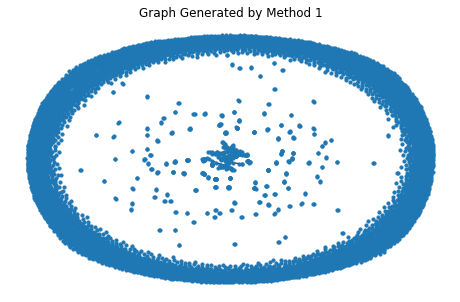

In [23]:
# draw preliminary graph 
fig, ax = plt.subplots(figsize=(8,5))

nx.draw(G, node_size=10, ax=ax)
ax.set_title(f'Graph Generated by Method 1')

plt.show()

The mass of indistinguishable nodes are made up of isolated Tweets with no edges. Since these Tweets are not members of any clusters, the team chose to remove isolates from the graph. 

In [24]:
# remove isolates
G.remove_nodes_from(list(nx.isolates(G)))
print(f'Number of nodes: {G.number_of_nodes():,}')
print(f'Number of edges: {G.number_of_edges():,}')

Number of nodes: 714
Number of edges: 2,348


In [25]:
# identify clusters (sub graphs)
sub_graphs = nx.connected_components(G)

# loop through all nodes in each sub graph
for i, sub in enumerate(sorted(sub_graphs, key=len, reverse=True)):
    df.loc[sub, 'M1_ClusterID'] = i # store cluster id
    print (f'Subgraph {i} consists of {len(sub)} tweets.')

Subgraph 0 consists of 117 tweets.
Subgraph 1 consists of 103 tweets.
Subgraph 2 consists of 16 tweets.
Subgraph 3 consists of 13 tweets.
Subgraph 4 consists of 12 tweets.
Subgraph 5 consists of 11 tweets.
Subgraph 6 consists of 10 tweets.
Subgraph 7 consists of 8 tweets.
Subgraph 8 consists of 8 tweets.
Subgraph 9 consists of 7 tweets.
Subgraph 10 consists of 7 tweets.
Subgraph 11 consists of 7 tweets.
Subgraph 12 consists of 7 tweets.
Subgraph 13 consists of 6 tweets.
Subgraph 14 consists of 6 tweets.
Subgraph 15 consists of 5 tweets.
Subgraph 16 consists of 5 tweets.
Subgraph 17 consists of 5 tweets.
Subgraph 18 consists of 5 tweets.
Subgraph 19 consists of 5 tweets.
Subgraph 20 consists of 4 tweets.
Subgraph 21 consists of 4 tweets.
Subgraph 22 consists of 4 tweets.
Subgraph 23 consists of 4 tweets.
Subgraph 24 consists of 4 tweets.
Subgraph 25 consists of 4 tweets.
Subgraph 26 consists of 4 tweets.
Subgraph 27 consists of 4 tweets.
Subgraph 28 consists of 4 tweets.
Subgraph 29 con

Removing isolate nodes reduced the noise in the graph by lowering the node count from 6,526 to 714. The new graph was redrawn and expanded with the Fruchterman Reingold layout. The second plot below better shows the two largest clusters with 117 and 103 tweets. 

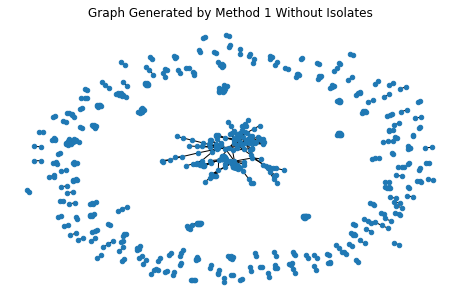

Elapsed time: 3.8913 seconds


In [26]:
t.start()

# draw graph 
fig, ax = plt.subplots(figsize=(8,5))

nx.draw(G, node_size=20, ax=ax)
ax.set_title(f'Graph Generated by Method 1 Without Isolates')

plt.show()

t.stop()

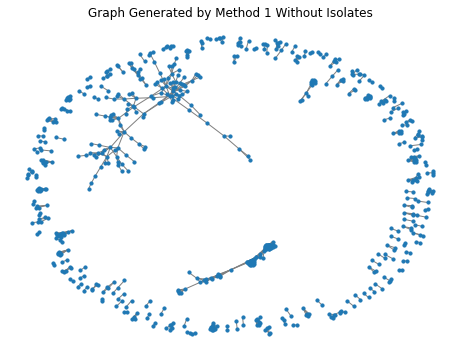

Elapsed time: 19.1141 seconds


In [27]:
t.start() 

# redraw graph with fruchterman reingold layout
count = G.number_of_nodes()
equilibrium = 7 / sqrt(count)    
pos = nx.fruchterman_reingold_layout(G, k=equilibrium, iterations=300)

fig, ax = plt.subplots(figsize=(8,6))

nx.draw(G, pos=pos, node_size=10, edge_color='gray', ax=ax)
ax.set_title(f'Graph Generated by Method 1 Without Isolates')

plt.show()


t.stop()

Samples of tweets from the two largest clusters can be seen below. 

In [28]:
print('Sample tweets from cluster 0:', end='\n\n')
for row in df.loc[df.M1_ClusterID==0].sample(5).itertuples():
    print(row.id, f'@{row.screen_name}:', '\n', row.text, end='\n\n')

print('\nSample tweets from cluster 1:', end='\n\n')
for row in df.loc[df.M1_ClusterID==1].sample(5).itertuples():
    print(row.id, f'@{row.screen_name}:', '\n', row.text, end='\n\n')

Sample tweets from cluster 0:

1398243202877034497 @VinVinPhilly: 
 b'@RepBrianFitz So I guess you will be voting for the infrastructure bill!'

1399838123362684934 @MinnesotaCitiz1: 
 b"@CawthornforNC Your bill doesn't do anything to build any actual broadband infrastructure if I recall. Isn't it jus\xe2\x80\xa6 https://t.co/GeMO9XMruE"

1400129272061251586 @HelenDa34407116: 
 b'I believe we have infrastructure that needs to be worked on so maybe we need to just do that.  Don\xe2\x80\x99t add any other\xe2\x80\xa6 https://t.co/gNaOfz0PdR'

1400247911242506240 @JimSchef: 
 b'@washingtonpost Well then they should have two bills. One that actually addresses just infrastructure and another t\xe2\x80\xa6 https://t.co/TCguDcGh7M'

1398779374199984132 @dpw_98: 
 b'@jordanbpeterson The reason they have to shoehorn things like this into the infrastructure bill is because of how d\xe2\x80\xa6 https://t.co/WlDPldgSDX'


Sample tweets from cluster 1:

1398021994403221504 @tmsnbb: 
 b'#Arkansas Cl

Unfortunately, this technique leaves most of the tweets without a cluster assignment. Of the 6,526 tweets present, 5,812 are isolates and outside a cluster. 

In [29]:
num_no_cluster = df.M1_ClusterID.isna().sum()
print(f'Number of tweets with no M1 cluster ID: {num_no_cluster:,} out of {df.shape[0]:,}')

Number of tweets with no M1 cluster ID: 5,812 out of 6,526


### Method 2

Method 2's clustering uses a combination of k-means clustering and the Term Frequency - Inverse Document Frequency (TF-IDF) metric. First the Tweet vectors are weighted using TF-IDF to reduce the vector component value of commonly used words. TF-IDF is a product of two other metrics: Term Frequency (TF) and Inverse Document Frequency (IDF). Term frequency $tf(t,d)$ is the frequency of term $t$ appearing in Tweet $d$ and is given by
$$ \text{tf}(t,d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}}$$
where $f_{t,d}$ is the number of times term $t$ appears in Tweet $d$. Inverse Document Frequency is a measure of how important each word is among the Tweets and is given by
$$ \text{idf}(t, D) = \log \frac{N}{| {d \in D : t \in d} |} $$
where $N$ is the total number of Tweets, and $| {d \in D : t \in d} |$ is the number of Tweets in which term $t$ appears. TF-IDF is simply a product of TF and IDF; its value for a given word in a Tweet increases as the word appears more frequently in the Tweet but decreases if a large number of Tweets contain that word \cite{what_tfidf}. 


One key difference in this approach is that the Word2Vec representation of Method 1 used a pretrained vocabulary while the TF-IDF vectorization of Method 2 generates a new vocabulary based on the dataset content. 

Once the vectorized Tweets have been reweighted using TF-IDF, the k-means clustering algorithm will be performed to generate clusters of similar Tweets using the Euclidean distance.
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [30]:
t.start()

# initialize tf-idf vectorizer
vectorizer = TfidfVectorizer()

In [31]:
# build document-term matrix
X = vectorizer.fit_transform(df.tokens.apply(lambda x: ' '.join(x)).array)

t.stop()

Elapsed time: 0.4564 seconds


After vectorization, the resulting list of feature words and vocabulary can be observed. 
The resulting TF-IDF matrix $X$ features 6,526 rows of Tweets and 8,655 columns of features.

In [32]:
vectorizer.get_feature_names()

['00',
 '000',
 '009s',
 '01',
 '05',
 '05am',
 '06',
 '08',
 '0k',
 '10',
 '100',
 '1000000',
 '100bn',
 '100k',
 '100th',
 '10billion',
 '10k',
 '10s',
 '10x',
 '11',
 '110',
 '1100',
 '113',
 '114',
 '115',
 '115bn',
 '117',
 '118',
 '11a',
 '11bn',
 '11th',
 '12',
 '125',
 '126',
 '13',
 '130',
 '1303',
 '133',
 '134b',
 '14',
 '140',
 '1400',
 '142',
 '147',
 '15',
 '156',
 '16',
 '165',
 '17',
 '174b',
 '18',
 '180',
 '180b',
 '180s',
 '1863',
 '1890',
 '19',
 '1900',
 '1946',
 '1950s',
 '1960',
 '1980',
 '1993',
 '19b',
 '1bil',
 '1limiting',
 '1st',
 '1t',
 '1trillion',
 '20',
 '200',
 '2000',
 '2001',
 '2005',
 '2009',
 '200b',
 '200k',
 '2010',
 '2012',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '202',
 '2020',
 '2021',
 '2022',
 '2024',
 '2025',
 '2030',
 '2035',
 '2070',
 '20k',
 '20th',
 '21',
 '213',
 '2165',
 '21st',
 '22',
 '224',
 '225b',
 '23',
 '24',
 '25',
 '250',
 '250k',
 '2561',
 '257',
 '257bil',
 '25b',
 '26',
 '260',
 '27',
 '270',
 '275',
 '28',
 '29',
 '2

In [33]:
vectorizer.vocabulary_

{'problem': 6093,
 'biden': 1004,
 'wh': 8453,
 'pitches': 5829,
 'step': 7381,
 'planthe': 5849,
 'bill': 1023,
 'infrastructure': 4080,
 'spe': 7265,
 'joe': 4294,
 'manchin': 4773,
 'bipartisan': 1046,
 'personally': 5765,
 'hopes': 3816,
 'beating': 925,
 'game': 3346,
 'passy': 5676,
 'wo': 8535,
 'endthefilibuster': 2712,
 'endworkingwithtrumplicans': 2716,
 'pass': 5665,
 'infrastructurebill': 4081,
 'moscowmitch': 5090,
 'makes': 4758,
 'wonder': 8543,
 'spoken': 7296,
 'final': 3094,
 'reconciliation': 6393,
 'lo': 4641,
 'trillion': 7962,
 'compromise': 1748,
 'joke': 4306,
 'amounts': 581,
 'bending': 964,
 'knee': 4400,
 'mitch': 5023,
 'mcconne': 4856,
 'republiqans': 6575,
 'gon': 3456,
 'na': 5138,
 'vote': 8310,
 'em': 2664,
 'omg': 5441,
 'sick': 7092,
 'pos': 5947,
 'nope': 5293,
 'tax': 7657,
 'cuts': 2079,
 '2017': 81,
 'gets': 3398,
 'deal': 2150,
 'ok': 5428,
 'offerin': 5391,
 'calls': 1309,
 'golden': 3452,
 'opportunity': 5480,
 'warns': 8378,
 'eliminatingcoal

In [34]:
# get shape of TF-IDF matrix
X.shape

(6526, 8655)

Now the series of k-means clustering models are generated to determine the optimal number of clusters, $k$. Both inertia and silhouette are used to assess the performance of each cluster count. The silhouette coefficient is computed after cluster creation and is a measure of how well defined the clusters are. The silhouette coefficient $s$ is defined as

$$ s = \frac{b-a}{\max (a, b)} $$

where $a$ is the mean distance between a Tweet and all other Tweets in the same cluster and $b$ is the mean distance between a Tweet and all other Tweets in the next nearest cluster. Each Tweet has its own silhouette score; Tweets among a cluster can be averaged to achieve a silhouette coefficient for the cluster, or every Tweet's silhouette coefficient can be averaged to determine the entire model's silhouette score. Silhouette values range between -1 to 1 where values closer to 1 indicate dense clusters with clear boundaries between clusters. 

$k$-means clustering is performed with $k$ ranging from 2 to 50 to determine which cluster count is the most beneficial.

In [35]:
t.start()

# initialize range of k-values to consider and lists to store inertia and silhouette scores
K = range(2, 51)
inertia = []
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
    
t.stop()

Elapsed time: 170.2637 seconds


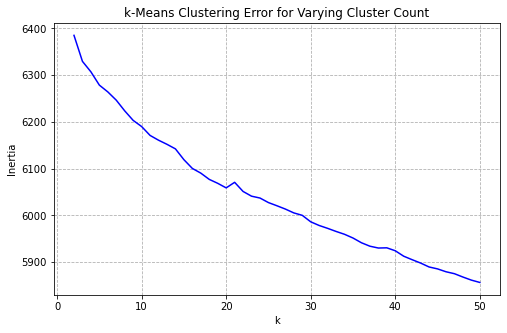

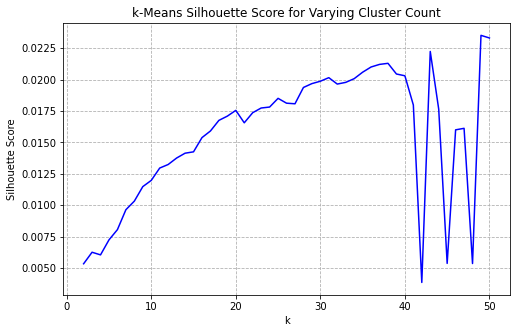

In [36]:
def plot_linegraph(x, y, title, xlabel, ylabel):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.plot(x, y, color='b')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(linestyle='--') 

    plt.show()
    
    
plot_linegraph(K, inertia, title='k-Means Clustering Error for Varying Cluster Count', 
             xlabel='k',
             ylabel='Inertia')

plot_linegraph(K, silhouette, title='k-Means Silhouette Score for Varying Cluster Count', 
             xlabel='k',
             ylabel='Silhouette Score')

In [37]:
# show silhouette score of each cluster count, k
pd.DataFrame(data={'K': K, 'sil': silhouette})

,K,sil
0,2,0.005347
1,3,0.006263
2,4,0.006053
3,5,0.007247
4,6,0.008062
5,7,0.009645
6,8,0.010329
7,9,0.011482
8,10,0.011977
9,11,0.012959


In [38]:
# cast to numpy array
K_np = np.array(K)
inertia_np = np.array(inertia)
silhouette_np = np.array(silhouette)

# find silhouette and inertia for 38 clusters
N=38
idx = np.where(K_np==N)[0][0]
print(f'Cluster count: {N}')
print(f'Inertia: {inertia_np[idx]:.2f}')
print(f'Silhouette: {silhouette_np[idx]:.4f}')

Cluster count: 38
Inertia: 5930.21
Silhouette: 0.0213


Examining the inertia and silhouette graphs above, it seems that the clusters have less intra-cluster error (lower inertia) and less overlap (higher silhouette) as $k$ increases. After about 38 clusters, the performance improvement is negligible. It seems that 38 clusters produces an average silhouette coefficient of 0.0213. 
We recluster with 38 clusters and store the cluster ids. 

In [39]:
t.start()

# recluster with 38 clusters
kmeans = KMeans(n_clusters=38, random_state=0).fit(X)

In [40]:
# store cluster id in df
df['M2_ClusterID'] = kmeans.labels_
df['M2_sil']  = silhouette_samples(X, kmeans.labels_)

In [41]:
df.M2_ClusterID.value_counts()

t.stop()

Elapsed time: 4.5227 seconds


The better clusters are denser and have higher silhouette scores. The silhouette coefficient of each of the 38 clusters are computed below.

In [42]:
df.groupby(by=['M2_ClusterID']).agg({'M2_sil': 'mean'}).sort_values('M2_sil', ascending=False)

,M2_sil
M2_ClusterID,
6,0.701978
11,0.391704
26,0.319609
34,0.092410
35,0.076626
22,0.066375
5,0.065551
15,0.064678
2,0.058642


Clusters 6, 11, and 26 are the most dense. The remaining clusters have silhouette coefficients below 0.1, which is indicative of poor clustering. Tweet samples from the top clusters are shown below.

In [43]:
cluster_ids = [6, 11, 26, 34, 35]
for cid in cluster_ids:
    print(f'\nSample tweets from cluster {cid}:', end='\n\n')
    for row in df.loc[df.M2_ClusterID==cid].sample(5).itertuples():
        print(row.id, f'@{row.screen_name}:', '\n', row.text, end='\n\n')


Sample tweets from cluster 6:

1399911885986803720 @bargdaffy161: 
 b'@morgfair @markets Sorry, but $2T over 10 years is only $200B per year, 1% of our GDP. America spends only 20% of G\xe2\x80\xa6 https://t.co/VcccfiVskd'

1399457360997928962 @bargdaffy161: 
 b'@kylegriffin1 Sorry, but $2T over 10 years is only $200B per year, 1% of our GDP. America spends only 20% of GDP on\xe2\x80\xa6 https://t.co/m0ggdFDjYM'

1400477828232134658 @bargdaffy161: 
 b'@RonWyden @All100Senators @registerguard Sorry, but $2T over 10 years is only $200B per year, 1% of our GDP. Americ\xe2\x80\xa6 https://t.co/t1c3QdNsFu'

1400536778923249668 @bargdaffy161: 
 b'@BN9 Sorry, but $2T over 10 years is only $200B per year, 1% of our GDP. America spends only 20% of GDP on Social I\xe2\x80\xa6 https://t.co/YZ0obtmMRa'

1399061196934877189 @bargdaffy161: 
 b'@guardian Sorry, but $2T over 10 years is only $200B per year, 1% of our GDP. America spends only 20% of GDP on Inf\xe2\x80\xa6 https://t.co/D2VnYMT7vD'


Sa

Unfortunately, cluster 6 is dense merely because the tweets contained within are nearly identical from a single user @bargdaffy161. 
Cluster 11 has phrases related to a meeting between biden and capito or to "real compromise". 
Cluster 26 has repeated use of the phrases "clean drinking water," "american jobs plan," "american families plan," and "infrastructure bill" from a single user @tmsnbb. 

The lower silhouette coefficient of the remaining clusters makes identifying distinctive pattern more difficult. For example, it is difficult to see why tweets in clusters 34 and 35 are grouped together when examining the samples above. 

## Step 3: Cluster Assessment

### Sentiment Analysis and Cluster Exploration

The VADER sentiment analyzer from nltk is used to assess the sentiment of each tweet. Then the sentiment distribution of each cluster is assessed.

In [44]:
t.start()

# get sentiment dictionary of each tweet
sia = SentimentIntensityAnalyzer()

df['SentDict'] = df.text_clean.apply(sia.polarity_scores)  # build dictionary
df['Sent'] = df.SentDict.apply(lambda x: 'pos' if x['pos'] > x['neg'] else ('neg' if x['pos'] < x['neg'] else 'neu')) # get overall sentiment of tweet

t.stop()

Elapsed time: 1.2343 seconds


In [45]:
# plot sentiment of each cluster by method 1
df_sum1 = df.groupby(by=['M1_ClusterID', 'Sent']).size().reset_index(name='count').pivot_table(index='M1_ClusterID', columns='Sent', fill_value=0.)
df_sum1.index = df_sum1.index.astype(int)
df_sum1.columns = [col[1] for col in df_sum1.columns] # flatten multi-index columns

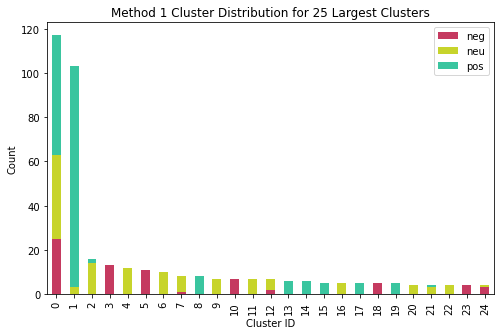

In [46]:
fig, ax = plt.subplots(figsize=(8,5))

N = 25
df_sum1[:N].plot.bar(stacked=True, ax=ax, color=['#C53A60', '#C7D42B', '#3AC59F'])
ax.set_title(f'Method 1 Cluster Distribution for {N} Largest Clusters')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Count')
ax.legend()

plt.show()

It seems that the largest cluster has a relatively even distribution of positive, neutral, and negative tweets while the second largest cluster (cluster 1) has primarily positive sentiment. A sample of each sentiment type from the largest two clusters can be seen below. 

In [47]:
# sample all sentiment types from first two clusters
cluster_ids = [0, 1]
sentiments = ['neg', 'neu', 'pos']
for cid in cluster_ids:
    for sent in sentiments:
        N = min(5, df.loc[(df.M1_ClusterID==cid) & (df.Sent==sent)].shape[0])
        if N>0:
            print(f'\nSample tweets from cluster {cid}, {sent}:', end='\n\n')
            for row in df.loc[df.M1_ClusterID==cid].sample(N).itertuples():
                print(row.id, f'@{row.screen_name}:', '\n', row.text_clean, end='\n\n')


Sample tweets from cluster 0, neg:

1399838123362684934 @MinnesotaCitiz1: 
 your bill doesn't do anything to build any actual broadband infrastructure if i recall. isn't it jus

1398250558834757639 @Vickitkd: 
 sounds like an infrastructure issue. i hear there's a bill for that.... you might have to vote to do

1400561192343457794 @Karississima: 
 stop this right now! the gop isn't going to support the bill, no matter how much it's compromised. just stop.

1398243202877034497 @VinVinPhilly: 
 so i guess you will be voting for the infrastructure bill!

1400596273544171521 @BryanMittler: 
 he literally can expect that if you want any infrastructure. the original bill


Sample tweets from cluster 0, neu:

1398418394001534976 @Danos65: 
 isn't it a good thing president biden wants to pass the bill for infrastructure that u seem to be against. why is that?

1400570555263197186 @RobertaLavin: 
 you could vote for the infrastructure bill and then you would have the money.

140059293505865318

In [48]:
# sample all sentiment types from other large clusters
cluster_ids = [2, 3, 4, 5, 6, 7, 8]
sentiments = ['neg', 'neu', 'pos']
for cid in cluster_ids:
    for sent in sentiments:
        N = min(5, df.loc[(df.M1_ClusterID==cid) & (df.Sent==sent)].shape[0])
        if N>0:
            print(f'\nSample tweets from cluster {cid}, {sent}:', end='\n\n')
            for row in df.loc[df.M1_ClusterID==cid].sample(N).itertuples():
                print(row.id, f'@{row.screen_name}:', '\n', row.text, end='\n\n')


Sample tweets from cluster 2, neu:

1399299944100532226 @drstoddard48: 
 b"'Real compromise' on U.S. infrastructure bill possible - Republican senator https://t.co/fcLhb87lWl via @Yahoo The\xe2\x80\xa6 https://t.co/0tnHmBigmX"

1399247420278538242 @Orion1557: 
 b"'Real compromise' on U.S. infrastructure bill possible - Republican senator https://t.co/uJbCiZ5hL0 via @YahooNews"

1399156985367572481 @readmoreabout: 
 b"'Real compromise' on U.S. infrastructure bill possible - Republican senator - https://t.co/dBy6TNQBau"

1399039380648509447 @VIXC_News: 
 b"'Real compromise' on U.S. infrastructure bill possible - Republican senator - https://t.co/auJN6amXlf #VIXC\xe2\x80\xa6 https://t.co/Tjh3jlQZoO"

1399315924138799105 @thisisinfraday: 
 b"'Real compromise' on U.S. infrastructure bill possible - Republican senator https://t.co/cfbs7JmMqI #infrastructure"


Sample tweets from cluster 2, pos:

1399120278391775239 @lmcameron1313: 
 b"'Real compromise' on U.S. infrastructure bill possible -

Clusters 2 to 8 contains Tweets that are very similar with slight variation. 

- Cluster 2: Tweets about compromise on the infrastructure bill from multiple users
- Cluster 3: Tweets about Gladys Sicknick from one user (@Joseph_E_Faith) to multiple users
- Cluster 4: Tweets about number of votes from one user (@kristiwelshies) to multiple users
- Cluster 5: Tweets about budget of bill from one user (@bardaffy160) to multiple users
- Cluster 6: Tweets about Sinema and Manchin from one user (@fiona_webster22) to multiple users
- Cluster 7: Tweets about Senate Democrats working with or without Republicans from multiple users
- Cluster 8: Tweets about Mitch McConnell stalling from one user (@Holley77karen) to multiple users

Every Tweet in cluster 2 involves a phrase related to the "compromise" of the infrastructure bill while every Tweet in cluster 7 is about Democrats working with or without Republicans. Cluster 1 has Tweets from a single user regarding repeated use of the words "clean drinking water," "american jobs plan," and "american families plan."

Clusters 3, 4, 5, 6, and 8 have quasi-identical Tweets from one user repeatedly sent to multiple users. Examining the individual Tweets shows that each Tweet has a different amount of truncation which resulted in the essentially duplicate Tweets passing the preprocessing stage.

In [49]:
# plot sentiment of each cluster by method 2
df_sum2 = df.groupby(by=['M2_ClusterID', 'Sent']).size().reset_index(name='count').pivot_table(index='M2_ClusterID', columns='Sent', fill_value=0.)
df_sum2.columns = [col[1] for col in df_sum2.columns] # flatten multi-index columns

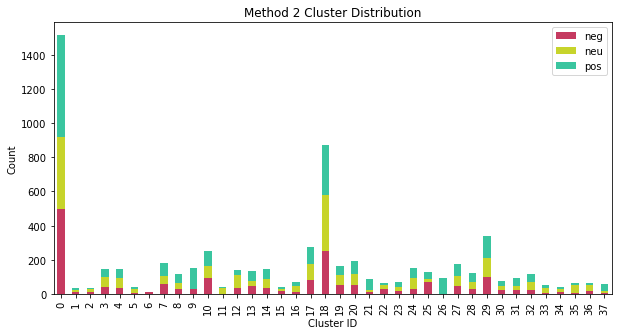

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

df_sum2.plot.bar(stacked=True, ax=ax, color=['#C53A60', '#C7D42B', '#3AC59F'])
ax.set_title(f'Method 2 Cluster Distribution')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Count')
ax.legend()

plt.show()

Each of the clusters from Method 2 have a relatively consistent distribution of positive, neutral, and negative Tweets. Tweets are sampled from the two largest clusters (0 and 18) and a few other clusters.

In [51]:
# sample all sentiment types from largest two clusters
cluster_ids = [0, 18]
sentiments = ['neg', 'neu', 'pos']
for cid in cluster_ids:
    for sent in sentiments:
        N = min(5, df.loc[(df.M2_ClusterID==cid) & (df.Sent==sent)].shape[0])
        if N>0:
            print(f'\nSample tweets from cluster {cid}, {sent}:', end='\n\n')
            for row in df.loc[df.M2_ClusterID==cid].sample(N).itertuples():
                print(row.id, f'@{row.screen_name}:', '\n', row.text_clean, end='\n\n')


Sample tweets from cluster 0, neg:

1398353425243463685 @SuperLuckeee: 
 we are now just waiting for the $aapl sector rotation move since $nvda $tsla $spy $abnb has now run. biden proposin

1398665811645059074 @ArvMaschino: 
 sorry to say it's a constitutional republic and the only one sabotaging is the democrats and by the way th

1400092395518185473 @SpiralBlanton: 
 you know why, but the quote from sen. casey lays out the real reason for the gridlock to make the bill

1398811478199840768 @MomOfTw48865399: 
 same here. i worry that the chinese gov't might download malware thru the app and then hack us in some

1400079744956211210 @brooklynpsu: 
 its funny what can happen when you dont make che guevara your campaign manager, senator coons s


Sample tweets from cluster 0, neu:

1400233622439968768 @Leopard24601: 
 he doesnt. reparations could come from the fed govt but congress hol

1399221199708688386 @NotACommiePlsD1: 
 omg thats the point, gaza is an open air prison due to the act

It is difficult to see how VADER distinguished positive Tweets from negative ones as many of the Tweets can be switched from one sentiment to the other. 

In [52]:
# sample all sentiment types from other clusters
cluster_ids = [1, 2, 3, 4, 5, 6, 7, 8, 11, 26]
sentiments = ['neg', 'neu', 'pos']
for cid in cluster_ids:
    for sent in sentiments:
        N = min(5, df.loc[(df.M2_ClusterID==cid) & (df.Sent==sent)].shape[0])
        if N>0:
            print(f'\nSample tweets from cluster {cid}, {sent}:', end='\n\n')
            for row in df.loc[df.M2_ClusterID==cid].sample(N).itertuples():
                print(row.id, f'@{row.screen_name}:', '\n', row.text_clean, end='\n\n')


Sample tweets from cluster 1, neg:

1400513257731936261 @speakingout13: 
 and the president  is caving in for the republicans. he's chipping away at his infrastruct

1399307581592686594 @CstmrDisservice: 
 add #hr1 and the #votingrightsact to the #infrastructure bill and ram it through the senate

1398320925536395265 @RolandBlasini: 
 pure bull crap propaganda and  from puta aoc  rep. greg steube: failure to pass $2.3t infrastruct

1398719510832615427 @casawasa: 
 stop trying to find compromise. the answer lies in doing whats right for the #americanpeople.  pass an infrastruct

1400308912360992773 @CoughingHillary: 
 this ruling essentially defeats hr1, the proact, and much of what is included in the current infrastructure bill.


Sample tweets from cluster 1, neu:

1398674781386465285 @DarkFluid2: 
 bernie, you know you can do that by yourself if you choose to vote no on things like the infrastructure bill until hr1 passes.

1400175725781696521 @apoorpoet: 
 which is why i give manch

When examining clusters 1 to 8, some clusters can be defined by key words while it is difficult to determine why other clusters were formed. 

- Cluster 1: unknown
- Cluster 2: Tweets about reading the bill from multiple users
- Cluster 3: unknown
- Cluster 4: Tweets about passing the infrastructure bill from multiple users
- Cluster 5: unknown
- Cluster 6: Tweets about budget of bill from one user (@bardaffy160) to multiple users
- Cluster 7: unknown
- Cluster 8: unknown

The team first reviewed the clusters with the highest silhouette cofficients as given in Table 2. The best cluster, Cluster 6, contains Tweets from one user (@bardaffy160) regarding the \$2 trillion cost of the infrastructure bill. Cluster 11 contains Tweets related to compromise on the infrastructure bill from multiple users. Cluster 26 has Tweets from a single user regarding repeated use of the words "clean drinking water," "american jobs plan," and "american families plan'' which is similar to Method 1's Cluster 1. The remaining Method 2 clusters were also assessed, and less than half of the clusters can be explained with single features. This is expected given the low silhouette coefficients of the remaining clusters indicating significant overlap. For example, when examining clusters 1 to 5, Cluster 2 includes Tweets from multiple users about actually reading the bill, and Cluster 4 references passing the bill. However, Clusters 1, 3, and 5 have no recognizable themes. In other smaller clusters, Tweets are very similar but differ with varying truncation.

### Run Time Comparison

The tables below summarize the performance time when operating on the medium dataset.  

<br>
<center>Method 1 Run Time</center>

Component | Time (sec)
----|------:
Train vocabulary | 0.0000  
Vectorize Tweets | 12.6672 
Build similarity matrix | 0.3316 
Cluster Tweets | 3.0420 
Draw graph | 17.5952

<br><br>
<center>Method 2 Run Time</center>

Component | Time (sec)  
---|---:
Train Vocabulary, Vectorize Tweets | 0.5480  
Explore Optimal Cluster Count | 172.6904 
Cluster Tweets | 4.5098


For comparison, only vocabulary training, Tweet vectorization, and clustering can be examined as the common steps. Method 1 required no time for training the vocabulary since the pretrained English model from spaCy was used. Method 2's implementation of TF-IDF involved vocabulary training and Tweet vectorization. The combined time for training and vectorization is lower for Method 2 by factor of 23. Method 1 is slightly faster when clustering, but it is worth noting that Method 1 only assigns a cluster to non-isolates while Method 2 assigns a cluster to each Tweet.